# Guided fuzzing example
Demonstrates using an opposite approach to adversarial sample generation to create new inputs for a model that reduce the loss.

Some extra steps are thrown in, here and there, to prototype giving py-holmes additional information that it will need.

## Get a model, loss function, and optimizer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import variable
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import random
import numpy as np


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)  # Final fully connected layer that outputs our 10 labels

    def forward(self, x):
        if x.dim() == 4 and x.size()[1:4] == torch.Size([1, 28, 28]):
            # Reshape from [*, 1, 28, 28] to [*, 784]
            x = x.view(x.size()[0], x.size()[1] * x.size()[2] * x.size()[3])
        elif x.dim() == 2 and x.size() == torch.Size([28, 28]):
            # Reshape from [28, 28] to [1, 784]
            x = x.view(1, 784)
        else:
            raise ValueError(f"can't handle this shape of x: {x.size()}")
        # Forward pass
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        x = torch.tanh(x)

        x = F.softmax(x, dim=1)  # Convert to probabilities
        return x

# Set hyperparameters
EPOCHS = 50
LR = 0.001
EPS = 1e-8
BATCH_SIZE = 100

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"cuda device 0 is {torch.cuda.get_device_name(0)}")

# Instantiate the model
model = Net().to(device)
print(model)

# Define a loss function
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, eps=EPS)
print(optimizer)

# Load the model
model.load_state_dict(torch.load('ph_models/mnist/modeldate2023-04-22,11_48_48.321528_bs100_lr0.001_eps1e-08_epochs44_valacc0.9818.pth'))


# Apply random seed
def seed_all(s):
    random.seed(s)
    torch.manual_seed(s)
    np.random.seed(s)
    
chosen_seed = 0
seed_all(chosen_seed)

cuda:0
cuda device 0 is NVIDIA GeForce RTX 3080 Laptop GPU
Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Find all inputs that the model misclassifies

In [2]:
"""Create loaders for MNIST dataset"""
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

train_and_val_datasets = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_dataset = datasets.MNIST(
               root = 'data', 
               train = False, 
               transform = ToTensor()
)


# Split the training data into a training set and a validation set
validation_split = 0.11
shuffle_dataset = True
dataset_size = (len(train_and_val_datasets))
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create loaders for all 3 datasets
train_loader = torch.utils.data.DataLoader(train_and_val_datasets, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_and_val_datasets, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [3]:
"""Get val accuracy and all val inputs which the model misclassified"""
# Tracking variables
num_val_samples = 60000 - 53400
total_eval_accuracy = 0
total_correct = 0
sample_indices_misclassified = []

model.eval()
for sample_index in range(53400, 60000):
    x = train_and_val_datasets.data[sample_index]
    label = torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    label[0, train_and_val_datasets.targets[sample_index].item()] = 1

    x, label = x.to(device), label.to(device)
    x = x.to(torch.float32)     # Because the model expects float32
    x.requires_grad = True
    optimizer.zero_grad()
    output = model(x)
    if output.argmax().item() == label.argmax().item():
        total_correct += 1
    else:
        sample_indices_misclassified.append(sample_index)

print(f"Validation accuracy is {total_correct / num_val_samples}")
print(f"A total of {len(sample_indices_misclassified)} samples were misclassified: {sample_indices_misclassified}")

Validation accuracy is 0.9951515151515151
A total of 32 samples were misclassified: [53598, 53694, 54065, 54097, 54296, 54452, 54506, 54586, 54858, 54936, 54966, 55278, 55340, 55396, 55739, 55862, 55958, 55974, 56014, 56380, 56774, 57701, 57728, 57768, 57972, 58648, 58812, 59701, 59719, 59720, 59731, 59915]


## Repeatedly modify the input to reduce the loss
Also do some other things that py-holmes will do.

--------------------------------------------------------------------------------------------------------------------------------

ORIGINAL IMAGE:


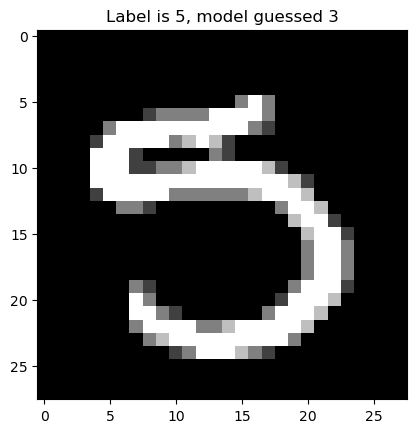

Original loss: 2.3431644439697266
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9787087440490723
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.00600019097328186
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   7.9982,   7.9959,   7.9974,   0.0000,   7.9958,   0.0000,
           0.0000,   7.9985,   0.0000,   7.9984,   0.0000,   7.9949,   7.9893,
           7.9952,   0.0000,   7.9973,   0.0000,   7.9912,   0.0000,   0.0000,
           7.9984,   7.9945,   7.9967,   0.0000,   7.9962,   0.0000,   0.0000],
        [  7.9979,   0.0000,   0.0000,   0.0000,   7.9886,   0.0000,   7.9966,
           7.9953,   7.9991,   7.9990,   7.9992,   7.9995,   7.9993,   0.0000,
           7.9992,   7.9968,   0.0000,   0.0000,   7.9982,   7.9980,   7.9978,
           7.9986,   7.9980,   7.9979,   0.0000,   0.0000,   0.0000,   7.9985],
        [  0.0000,   0.0000,   7.9074,   0.0000,   0.0000,   0.0

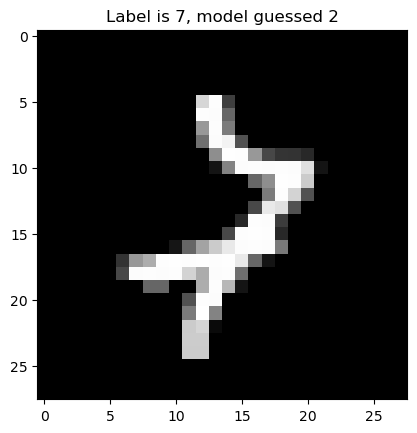

Original loss: 2.305143117904663
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
2.0908660888671875
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.006953060626983643
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[0.0000e+00, 1.3400e+01, 1.3179e+01, 1.3090e+01, 0.0000e+00, 1.3022e+01,
         0.0000e+00, 0.0000e+00, 1.3407e+01, 0.0000e+00, 1.3506e+01, 0.0000e+00,
         1.2901e+01, 1.3420e+01, 1.3408e+01, 0.0000e+00, 1.3074e+01, 0.0000e+00,
         1.2621e+01, 0.0000e+00, 0.0000e+00, 1.3463e+01, 1.3542e+01, 1.3654e+01,
         0.0000e+00, 1.3305e+01, 0.0000e+00, 0.0000e+00],
        [1.3504e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2393e+01, 0.0000e+00,
         1.3834e+01, 1.4585e+01, 1.3467e+01, 1.3611e+01, 1.3477e+01, 1.3431e+01,
         1.3589e+01, 0.0000e+00, 1.3483e+01, 1.4698e+01, 0.0000e+00, 0.0000e+00,
         1.3730e+01, 1.3579e+01, 1.3977e+01, 1.3447e+01, 1.3628e+01, 1.34

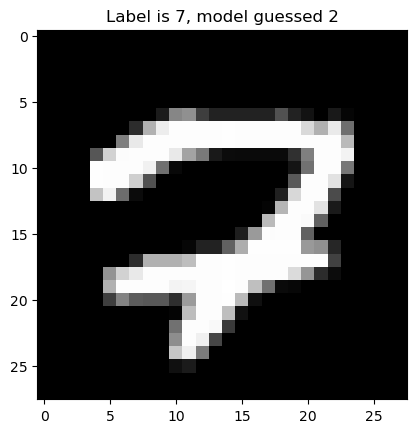

Original loss: 2.3167879581451416
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9727119207382202
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.017474263906478882
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[0.0000e+00, 1.5564e+01, 1.9659e+01, 1.9181e+01, 2.8552e+00, 1.8753e+01,
         0.0000e+00, 0.0000e+00, 1.5517e+01, 2.3507e+00, 1.9897e+01, 0.0000e+00,
         1.8940e+01, 8.5739e+00, 1.2149e+01, 0.0000e+00, 1.0060e+01, 0.0000e+00,
         7.7677e+00, 0.0000e+00, 0.0000e+00, 1.9866e+01, 1.9926e+01, 9.5341e+00,
         0.0000e+00, 1.9290e+01, 0.0000e+00, 4.9428e+00],
        [1.2524e+01, 0.0000e+00, 0.0000e+00, 4.3822e+00, 1.7669e+01, 4.2797e+00,
         1.9488e+01, 2.0100e+01, 1.9698e+01, 1.9683e+01, 1.9962e+01, 1.9619e+01,
         1.9403e+01, 3.6488e+00, 8.8162e+00, 9.8049e+00, 3.4686e+00, 4.1797e+00,
         1.9979e+01, 1.9221e+01, 1.9461e+01, 1.9500e+01, 1.9514e+01, 1.8

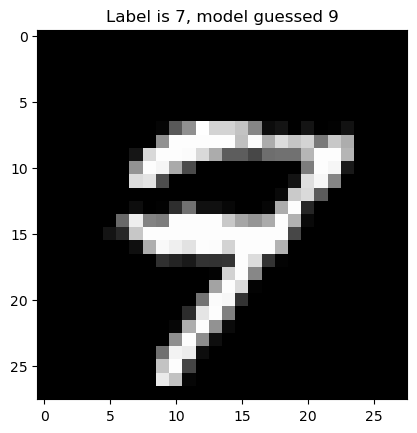

Original loss: 2.3464787006378174
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9593855142593384
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02819305658340454
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[0.0000e+00, 1.7336e+01, 2.4963e+01, 2.4168e+01, 5.1925e+00, 2.3446e+01,
         0.0000e+00, 0.0000e+00, 1.7246e+01, 4.2743e+00, 2.5130e+01, 0.0000e+00,
         2.3886e+01, 4.6027e+00, 1.1115e+01, 0.0000e+00, 7.5950e+00, 0.0000e+00,
         3.7925e+00, 0.0000e+00, 0.0000e+00, 2.5111e+01, 2.5151e+01, 6.1601e+00,
         0.0000e+00, 2.4196e+01, 0.0000e+00, 8.9907e+00],
        [1.1721e+01, 0.0000e+00, 0.0000e+00, 7.9732e+00, 2.1991e+01, 7.7870e+00,
         2.4124e+01, 2.4622e+01, 2.4806e+01, 2.4659e+01, 2.5278e+01, 2.4686e+01,
         2.4164e+01, 6.6364e+00, 4.9936e+00, 5.7961e+00, 6.3076e+00, 7.6016e+00,
         2.5100e+01, 2.3845e+01, 2.3954e+01, 2.4460e+01, 2.4337e+01, 2.34

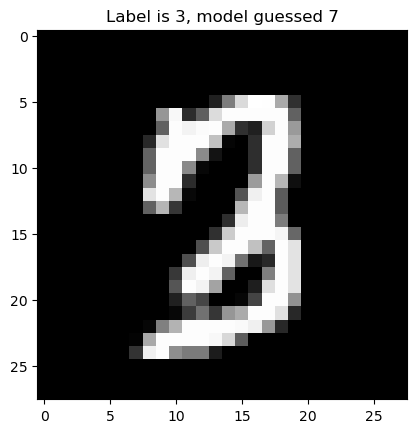

Original loss: 2.3037827014923096
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.959326148033142
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.04136642813682556
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[0.0000e+00, 1.8830e+01, 2.9409e+01, 2.8354e+01, 7.1478e+00, 2.7390e+01,
         0.0000e+00, 0.0000e+00, 1.8743e+01, 5.8730e+00, 2.9505e+01, 0.0000e+00,
         2.8056e+01, 1.2290e+00, 1.0212e+01, 0.0000e+00, 5.5538e+00, 0.0000e+00,
         4.2979e-01, 0.0000e+00, 0.0000e+00, 2.9559e+01, 2.9531e+01, 3.3131e+00,
         0.0000e+00, 2.8379e+01, 0.0000e+00, 1.2400e+01],
        [1.1041e+01, 0.0000e+00, 0.0000e+00, 1.1033e+01, 2.5647e+01, 1.0775e+01,
         2.8092e+01, 2.8501e+01, 2.9182e+01, 2.8880e+01, 2.9813e+01, 2.8946e+01,
         2.8160e+01, 9.1425e+00, 1.7596e+00, 2.3961e+00, 8.6758e+00, 1.0468e+01,
         2.9455e+01, 2.7780e+01, 2.7775e+01, 2.8683e+01, 2.8428e+01, 2.730

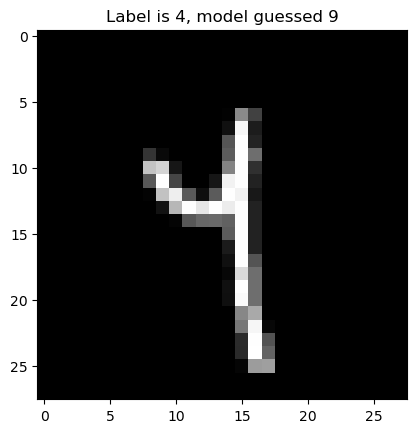

Original loss: 2.334481716156006
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.959322214126587
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.04701799154281616
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[0.0000e+00, 2.0117e+01, 3.3241e+01, 3.1962e+01, 8.8330e+00, 3.0789e+01,
         0.0000e+00, 0.0000e+00, 2.0032e+01, 7.2509e+00, 3.3276e+01, 0.0000e+00,
         3.1651e+01, 0.0000e+00, 9.4339e+00, 0.0000e+00, 3.7947e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3392e+01, 3.3306e+01, 8.5938e-01,
         0.0000e+00, 3.1985e+01, 0.0000e+00, 1.5339e+01],
        [1.0455e+01, 0.0000e+00, 0.0000e+00, 1.3669e+01, 2.8799e+01, 1.3349e+01,
         3.1512e+01, 3.1843e+01, 3.2954e+01, 3.2519e+01, 3.3721e+01, 3.2617e+01,
         3.1604e+01, 1.1302e+01, 0.0000e+00, 0.0000e+00, 1.0717e+01, 1.2938e+01,
         3.3209e+01, 3.1172e+01, 3.1068e+01, 3.2322e+01, 3.1954e+01, 3.0616

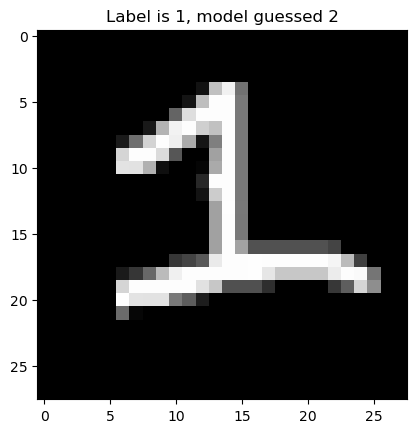

Original loss: 2.3491575717926025
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9593446254730225
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.05669569969177246
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[0.0000e+00, 2.1241e+01, 3.6587e+01, 3.5113e+01, 1.0304e+01, 3.3757e+01,
         0.0000e+00, 0.0000e+00, 2.1158e+01, 8.4539e+00, 3.6570e+01, 0.0000e+00,
         3.4790e+01, 0.0000e+00, 8.7534e+00, 0.0000e+00, 2.2583e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6740e+01, 3.6602e+01, 0.0000e+00,
         0.0000e+00, 3.5133e+01, 0.0000e+00, 1.7905e+01],
        [9.9426e+00, 0.0000e+00, 0.0000e+00, 1.5972e+01, 3.1552e+01, 1.5598e+01,
         3.4499e+01, 3.4762e+01, 3.6248e+01, 3.5696e+01, 3.7134e+01, 3.5823e+01,
         3.4612e+01, 1.3188e+01, 0.0000e+00, 0.0000e+00, 1.2498e+01, 1.5095e+01,
         3.6488e+01, 3.4134e+01, 3.3944e+01, 3.5500e+01, 3.5034e+01, 3.35

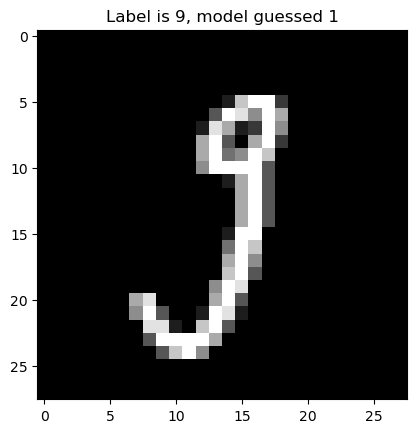

Original loss: 2.3491573333740234
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
2.242903709411621
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.0038448572158813477
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   7.8053,   0.0000,   7.7467,   6.9324,   0.0000,   0.0000,
           7.8079,   7.8812,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   7.3114,   7.8992,   0.0000,   6.2133,   7.9014,
           7.8433,   6.8531,   7.8910,   0.0000,   7.7662,   0.0000,   0.0000],
        [  7.5704,   7.8981,   0.0000,   0.0000,   7.8790,   7.8651,   0.0000,
           7.8903,   7.8639,   0.0000,   0.0000,   7.9822,   7.9835,   7.9812,
           0.0000,   7.9807,   7.9886,   7.9891,   7.4227,   7.9564,   7.9703,
           7.9721,   7.9522,   7.9086,   7.9037,   7.8833,   7.5897,   0.0000],
        [  7.8999,   7.8097,   7.5188,   7.9880,   7.9833,   0.

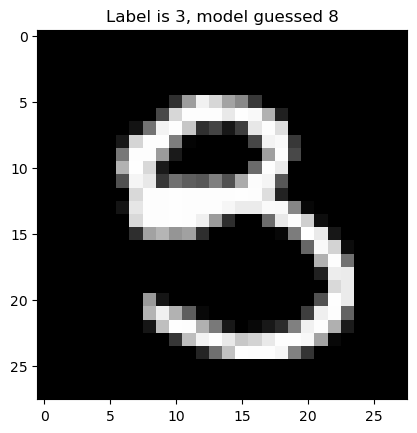

Original loss: 2.3086259365081787
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

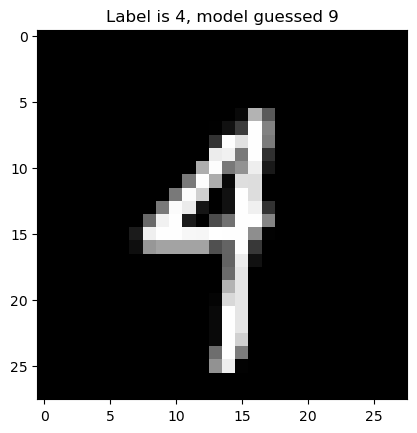

Original loss: 2.2779605388641357
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

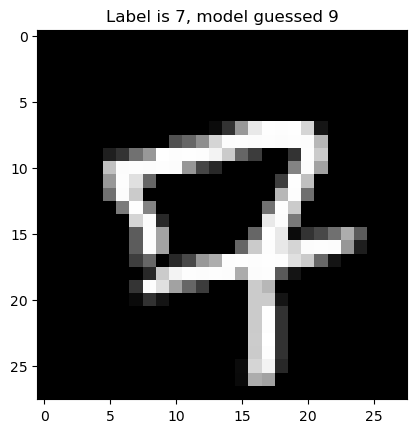

Original loss: 2.329134464263916
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

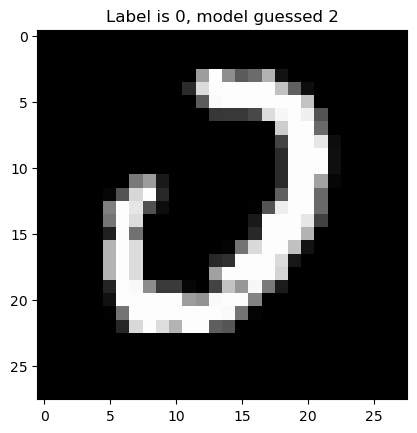

Original loss: 2.34867000579834
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.988

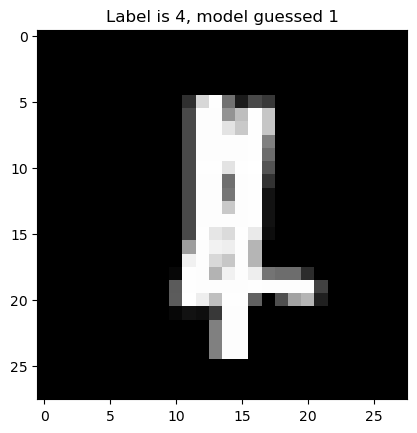

Original loss: 2.3491580486297607
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

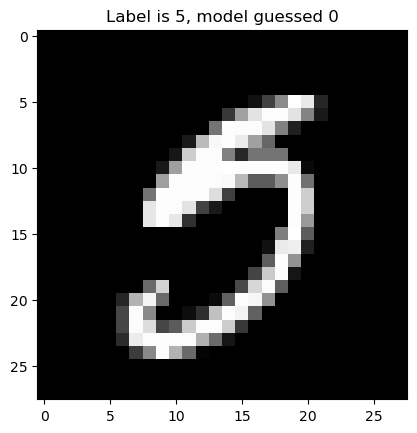

Original loss: 2.286026954650879
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

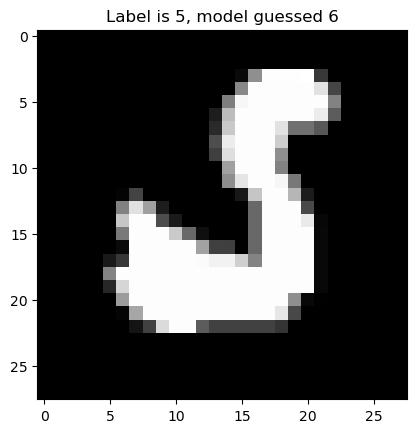

Original loss: 2.3068912029266357
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

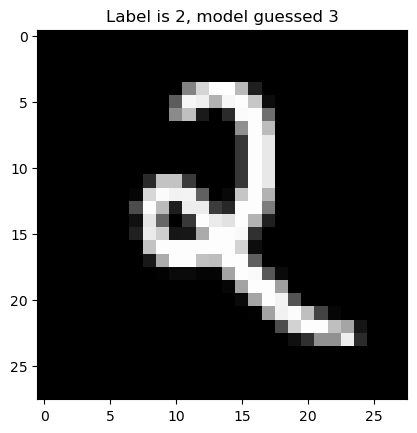

Original loss: 2.314566135406494
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

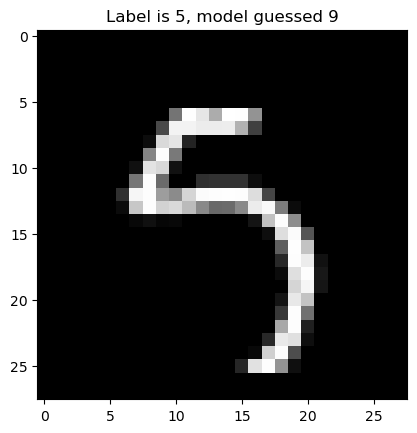

Original loss: 2.348635673522949
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

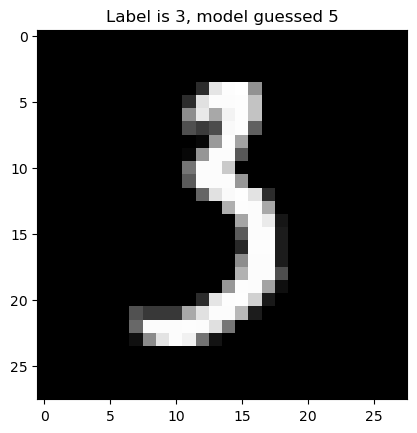

Original loss: 2.286553144454956
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

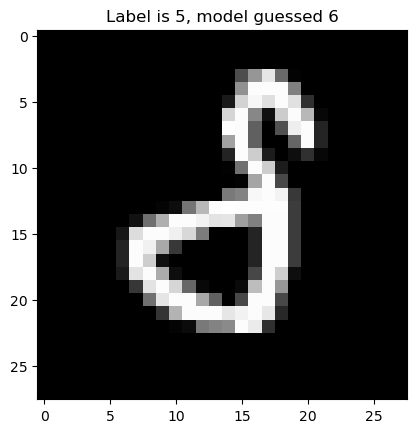

Original loss: 2.3487255573272705
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

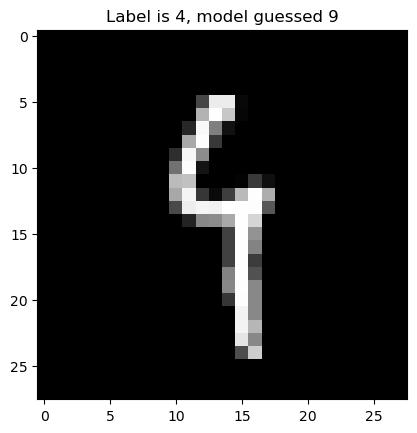

Original loss: 2.2973031997680664
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

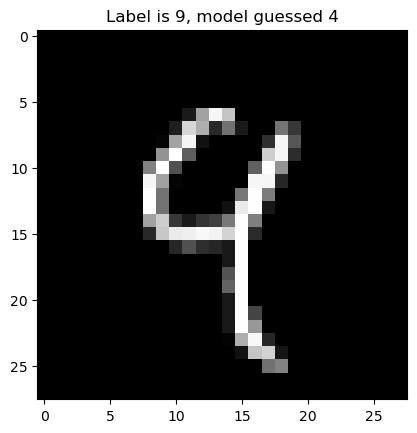

Original loss: 2.332766056060791
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

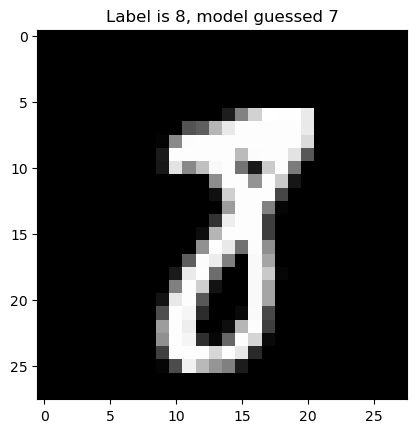

Original loss: 2.276445150375366
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

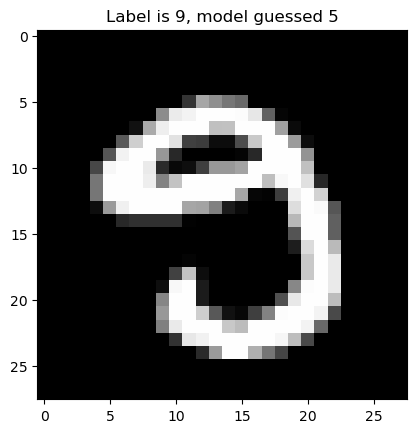

Original loss: 2.3454580307006836
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

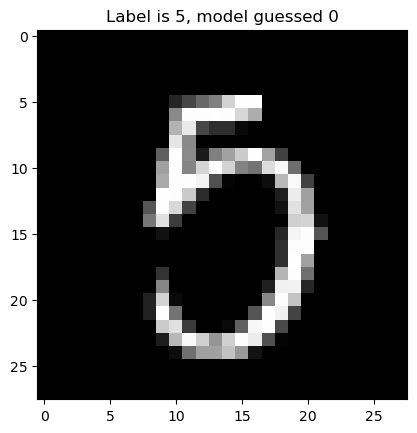

Original loss: 2.332432508468628
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

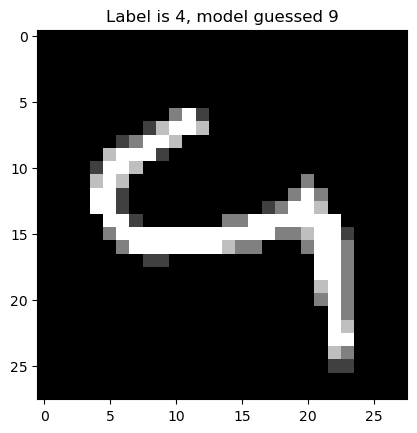

Original loss: 2.3491580486297607
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

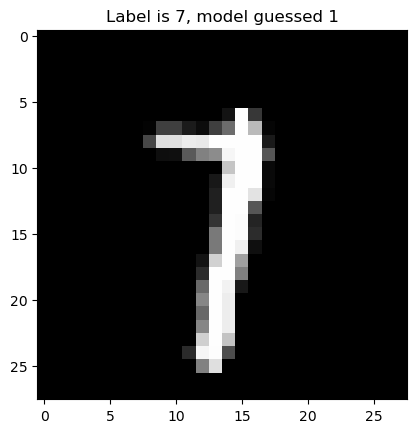

Original loss: 2.1036479473114014
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

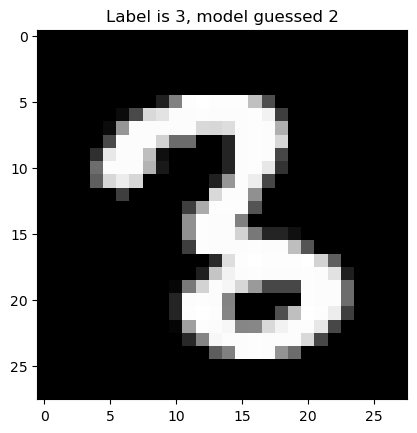

Original loss: 2.3219354152679443
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

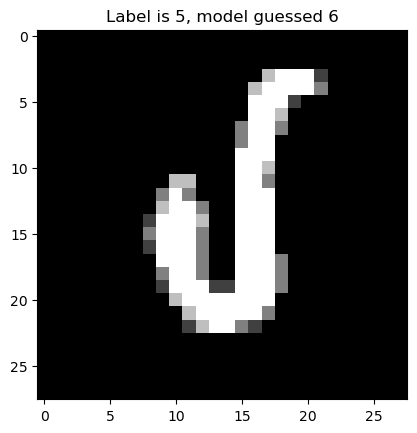

Original loss: 2.349196434020996
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.98

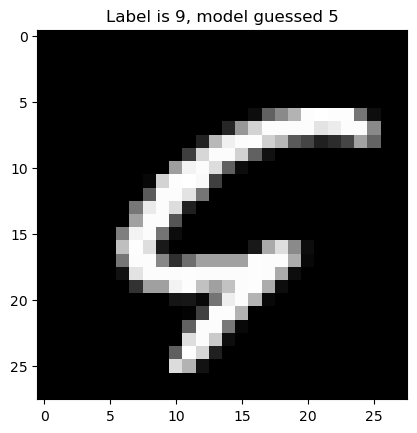

Original loss: 2.3491320610046387
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

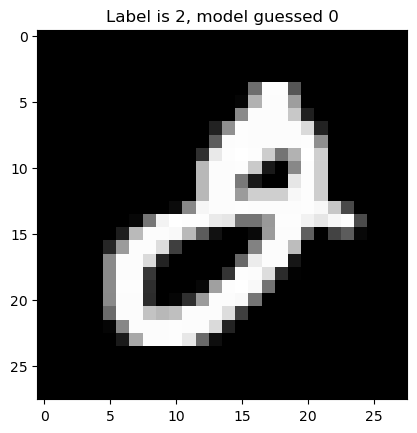

Original loss: 2.3491570949554443
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

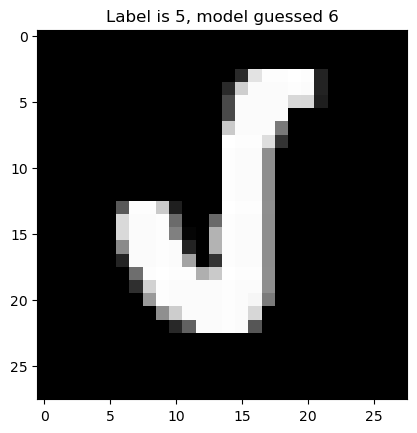

Original loss: 2.3489866256713867
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

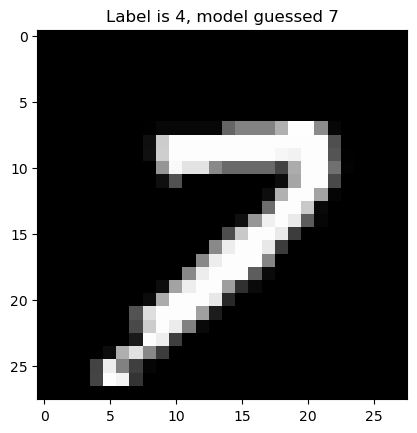

Original loss: 2.3491575717926025
//////////////////////// PASSING TEST ////////////////////////
~~~~~~~~~~~~~~~~ Loss ~~~~~~~~~~~~~~~~
1.9647431373596191
~~~~~~~~~~~~~~~~ Neuron Activation Distance from Original Input ~~~~~~~~~~~~~~~~
0.02966129779815674
~~~~~~~~~~~~~~~~ New Input x ~~~~~~~~~~~~~~~~
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   7.9896,   7.9788,   7.9843,
           7.9910,   0.0000,   7.9903,   7.9914,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   7.9916,   7.9369,   7.9919,   0.0000,
           7.9903,   0.0000,   0.0000,   7.9757,   0.0000,   7.9926,   0.0000],
        [  0.0000,   0.0000,   7.9920,   0.0000,   7.9922,   7.9903,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           7.9985,   7.9976,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  7.9930,   7.9933,   0.0000,   0.0000,   0.0000,   7.9

'\nprint(f"A passing input was found for a total of {num_samples_where_passing_input_was_found} samples")\n'

In [4]:
from colorama import Fore, Style
from ph_causal_testing import variant_test_runners
from ph_causal_testing.variant_test_runners import distance_between_neuron_activations

adjustment_rate = 8

diff_norm = colors.TwoSlopeNorm(vcenter=0)

num_samples_where_passing_input_was_found = 0

all_xs = []
all_activation_distances = []
all_did_pass = []
all_losses = []


def ph_get_activation(name):
    def hook(model, input, output):
        ph_activation[name] = output.detach()
    return hook

for sample_index in sample_indices_misclassified:
    print("-" * 128 + "\n")
    x = train_and_val_datasets.data[sample_index]
    label = torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    label[0, train_and_val_datasets.targets[sample_index].item()] = 1
    
    x, label = x.to(device), label.to(device)
    x = x.to(torch.float32)     # Because the dtype must be float or complex in order to set .requires_grad to True
    x_original = x.clone()
    
    # Add hooks
    for modulename in model._modules:
        eval(f"model.{modulename}.register_forward_hook(ph_get_activation('{modulename}'))")
    ph_activation = {}

    output = model(x)
    loss_original = loss_fn(output, label).item()

    ph_activation_original = ph_activation.copy()

    optimizer_for_input = torch.optim.Adam([x], lr=adjustment_rate)
    
    # The user has the option to create indices_to_protect_from_fuzzing
    indices_to_protect_from_fuzzing = [(0, 0), (5, 8)]

    # We then keep track of the values at those locations in x and prevent them from being fuzzed
    protection_indices_to_initial_values = {el: x[el].item() for el in indices_to_protect_from_fuzzing}

    print("ORIGINAL IMAGE:")
    plt.imshow(x.cpu().numpy(), cmap='gray', vmin=0, vmax=255)
    plt.title(f"Label is {train_and_val_datasets.targets[sample_index].item()}, model guessed {output.argmax().item()}")
    plt.show()

    for ii in range(1000):
        all_xs.append(x.clone())
        if not x.requires_grad:
            x.requires_grad = True
        optimizer.zero_grad()
        optimizer_for_input.zero_grad()

        # Reset activations
        ph_activation = {}

        output = model(x)
        loss = loss_fn(output, label)

        # Get activation distance from the original and store for future reference
        activation_distance = distance_between_neuron_activations(ph_activation, ph_activation_original)
        all_activation_distances.append(activation_distance)

        # Get whether passed and store for future reference
        try:
            assert output.argmax().item() == label.argmax().item()
            did_pass = True
        except AssertionError as err:
            did_pass = False
        all_did_pass.append(did_pass)

        # Store loss for future reference
        all_losses.append(loss.item())

        loss.backward()
        optimizer_for_input.step()
        x.requires_grad = False
        x[x<0] = 0
        x[x>255] = 255

        # Enforce any fuzzing protections set by the user
        for protection_indices in protection_indices_to_initial_values:
            x[protection_indices] = protection_indices_to_initial_values[protection_indices]
        """
        if output.argmax().item() == label.argmax().item():
            print("MODEL GUESSED CORRECTLY!")
            # Show final image
            plt.imshow(x.cpu().numpy(), cmap="gray", vmin=0, vmax=255)
            plt.title(f"Label is {train_and_val_datasets.targets[sample_index].item()}, model guessed {output.argmax().item()}")
            plt.show()
            # Show difference between images
            plt.imshow((x - x_original).cpu().numpy(), cmap="seismic", norm=diff_norm)
            plt.title("Changes from original input to arrive at fuzzed input")
            plt.colorbar()
            plt.show()
            num_samples_where_passing_input_was_found += 1
            break
        """
    
    # Remove the first run from certain lists, since the first run was just the input as-is.
    all_activation_distances = all_activation_distances[1:]
    all_did_pass = all_did_pass[1:]
    all_losses = all_losses[1:]
    all_xs = all_xs[1:]

    # Display a report in the style of py-holmes
    # Get the 3 most similar passing inputs and 3 most similar failing inputs
    most_similar_passing_indices = []
    most_similar_passing_distances = []
    most_similar_failing_indices = []
    most_similar_failing_distances = []
    
    for ii, did_pass in enumerate(all_did_pass):
        if did_pass:
            appropriate_indices_list = most_similar_passing_indices
            appropriate_distances_list = most_similar_passing_distances
        else:
            appropriate_indices_list = most_similar_failing_indices
            appropriate_distances_list = most_similar_failing_distances
        if len(appropriate_distances_list) < 3:
            appropriate_indices_list.append(ii)
            appropriate_distances_list.append(all_activation_distances[ii])
        elif all_activation_distances[ii] < min(appropriate_distances_list):
            position_to_replace = np.argmax(appropriate_distances_list)
            appropriate_indices_list[position_to_replace] = ii
            appropriate_distances_list[position_to_replace] = all_activation_distances[ii]
    # Create indices_for_showing
    indices_for_showing = most_similar_passing_indices + most_similar_failing_indices
    # Print the original loss
    print(f"Original loss: {loss_original}")
    for index_for_showing in indices_for_showing:
        # Print whether this result passed or failed, including a color code
        if all_did_pass[index_for_showing]:
            print(f"{Fore.GREEN}{'/'*24} PASSING TEST {'/'*24}{Style.RESET_ALL}")
        else:
            print(f"{Fore.RED}{'/'*24} FAILING TEST {'/'*24}{Style.RESET_ALL}")

        # Print the loss
        print(f"{Fore.BLUE}{'~' * 16} Loss {'~' * 16}{Style.RESET_ALL}")
        print(all_losses[index_for_showing])

        # Print the neuron activation difference
        print(f"{Fore.BLUE}{'~' * 16} Neuron Activation Distance from Original Input {'~' * 16}{Style.RESET_ALL}")
        print(all_activation_distances[index_for_showing])

        # Print the new input.  There would be little point highlighting the elements that were changed, because almost always, all elements will be changed.
        print(f"{Fore.BLUE}{'~' * 16} New Input x {'~' * 16}{Style.RESET_ALL}")
        print(all_xs[index_for_showing])


"""
print(f"A passing input was found for a total of {num_samples_where_passing_input_was_found} samples")
"""